# Анализ и прогнозирование покупательской активности для интернет-магазина "В один клик" 🛍️

Данный проект посвящён разработке системы прогнозирования для интернет-магазина "В один клик".

**Цель проекта:**

Создание модели машинного обучения, которая поможет интернет-магазину "В один клик" эффективно удерживать постоянных клиентов, используя данные анализа и бизнес-моделирования.

**Задачи проекта:**

- Построить модель, которая предскажет вероятность снижения покупательской активности постоянных клиентов в течение следующих трёх месяцев;
- Выполнить сегментацию покупателей, основываясь на результатах моделирования и данных о прибыльности клиентов;
- Предложить рекомендации для увеличения покупательской активности выделенного сегмента.

**План работы:**

1. **Обзор данных:**
    - Загрузка данных из всех источников;
    - Проверка структуры и содержания таблиц на соответствие описанию.


2. **Предобработка данных:**
    - Обработка пропусков, дубликатов и ошибок.


3. **Исследовательский анализ данных:**
    - Анализ распределений ключевых показателей;
    - Отбор клиентов, активных в течение последних трёх месяцев.
    
    
4. **Объединение таблиц:**
    - Создание единого датафрейма с ключевой информацией для моделирования;
    - Разделение данных по периодам для дальнейшего анализа.
    
    
5. **Корреляционный анализ:**
    - Изучение взаимосвязей между признаками;
    - Устранение мультиколлинеарности (при необходимости).
    
    
6. **Моделирование:**
    - Подготовка данных для обучения, включая кодирование категориальных признаков и масштабирование количественных;
    - Построение и настройка моделей (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC);
    - Выбор оптимальной модели на основе подходящей метрики.
    
    
7. **Анализ важности признаков:**
    - Определение значимости признаков для лучшей модели с использованием SHAP;
    - Выводы о влиянии признаков на целевой показатель.
    
    
8. **Сегментация клиентов:**
    - Выделение сегментов покупателей, основываясь на данных о моделировании и прибыльности;
    - Разработка рекомендаций для повышения покупательской активности выделенного сегмента.
    
    
9. **Общий вывод:**
    - Подведение итогов по проекту;
    - Выводы о ключевых факторах, влияющих на покупательскую активность.

**Описание данных:**
- **market_file.csv**: поведение на сайте, маркетинговая активность, предпочтения покупок.
- **market_money.csv**: информация о выручке за разные периоды.
- **market_time.csv**: время, проведённое на сайте.
- **money.csv**: прибыль от клиентов за последние три месяца.

## Обзор данных

### Загрузка и изучение данных

In [1]:
# Установка необходимых библиотек
!pip install -q phik
!pip install -q shap
!pip install -Uq scikit-learn

In [2]:
# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik import resources, phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap

In [3]:
# Загрузка данных в датафреймы pandas
market_file_df = pd.read_csv('Datasets/market_file.csv', sep=',')
market_money_df = pd.read_csv('Datasets/market_money.csv', sep=',')
market_time_df = pd.read_csv('Datasets/market_time.csv', sep=',')
money_df = pd.read_csv('Datasets/money.csv', sep=';', decimal=',')

In [4]:
# Функция для общего обзора данных
def data_overview(df, name):
    print(f"Обзор данных: {name}")
    print(f"Размер данных: {df.shape[0]} строк и {df.shape[1]} столбцов.")
    print("\nПервые 3 строки данных:")
    display(df.head(3))
    print("\nОбщая информация о данных:")
    print("---------------------------------------")
    df.info()
    print("\nСтатистика по числовым столбцам:")
    print("---------------------------------------")
    display(df.describe().round(2))
    print("\nПроверка явных дубликатов")
    print("---------------------------------------")
    duplicates = df.duplicated().sum()
    print(f"Количество явных дубликатов: {duplicates}\n")
    print("Проверка пропусков")
    print("---------------------------------------")
    check_missing_values(df)
    
# Функция для проверки пропусков
def check_missing_values(df):
    frame = {
        'nan_qty': df.isna().sum().sort_values(ascending=False),
        'nan_percent': (df.isna().mean() * 100).sort_values(ascending=False).map('{:.2f}%'.format)
    }
    nan_df = pd.DataFrame(frame)
    nan_df_styled = nan_df.style.background_gradient(subset=['nan_qty'], cmap='Oranges')
    display(nan_df_styled)

In [5]:
# Обзор данных
data_overview(market_file_df, "Поведение покупателей и коммуникации")
data_overview(market_money_df, "Данные о выручке")
data_overview(market_time_df, "Данные о времени на сайте")
data_overview(money_df, "Данные о прибыли")

Обзор данных: Поведение покупателей и коммуникации
Размер данных: 1300 строк и 13 столбцов.

Первые 3 строки данных:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5



Общая информация о данных:
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_к

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00



Проверка явных дубликатов
---------------------------------------
Количество явных дубликатов: 0

Проверка пропусков
---------------------------------------


,nan_qty,nan_percent
id,0,0.00%
Покупательская активность,0,0.00%
Тип сервиса,0,0.00%
Разрешить сообщать,0,0.00%
Маркет_актив_6_мес,0,0.00%
Маркет_актив_тек_мес,0,0.00%
Длительность,0,0.00%
Акционные_покупки,0,0.00%
Популярная_категория,0,0.00%
Средний_просмотр_категорий_за_визит,0,0.00%


Обзор данных: Данные о выручке
Размер данных: 3900 строк и 3 столбцов.

Первые 3 строки данных:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0



Общая информация о данных:
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

Статистика по числовым столбцам:
---------------------------------------


,id,Выручка
count,3900.00,3900.00
mean,215997.50,5025.70
std,375.33,1777.70
min,215348.00,0.00
25%,215672.75,4590.15
50%,215997.50,4957.50
75%,216322.25,5363.00
max,216647.00,106862.20



Проверка явных дубликатов
---------------------------------------
Количество явных дубликатов: 0

Проверка пропусков
---------------------------------------


,nan_qty,nan_percent
id,0,0.00%
Период,0,0.00%
Выручка,0,0.00%


Обзор данных: Данные о времени на сайте
Размер данных: 2600 строк и 3 столбцов.

Первые 3 строки данных:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10



Общая информация о данных:
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

Статистика по числовым столбцам:
---------------------------------------


,id,минут
count,2600.00,2600.00
mean,215997.50,13.34
std,375.35,4.08
min,215348.00,4.00
25%,215672.75,10.00
50%,215997.50,13.00
75%,216322.25,16.00
max,216647.00,23.00



Проверка явных дубликатов
---------------------------------------
Количество явных дубликатов: 0

Проверка пропусков
---------------------------------------


,nan_qty,nan_percent
id,0,0.00%
Период,0,0.00%
минут,0,0.00%


Обзор данных: Данные о прибыли
Размер данных: 1300 строк и 2 столбцов.

Первые 3 строки данных:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13



Общая информация о данных:
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

Статистика по числовым столбцам:
---------------------------------------


,id,Прибыль
count,1300.00,1300.00
mean,215997.50,4.00
std,375.42,1.01
min,215348.00,0.86
25%,215672.75,3.30
50%,215997.50,4.04
75%,216322.25,4.67
max,216647.00,7.43



Проверка явных дубликатов
---------------------------------------
Количество явных дубликатов: 0

Проверка пропусков
---------------------------------------


,nan_qty,nan_percent
id,0,0.00%
Прибыль,0,0.00%


### Приведение названий столбцов к единому стилю оформления

In [6]:
# Функция для преобразования названий столбцов
def rename_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r'[^\w\s]', '', regex=True)
        .str.replace(' ', '_')
        .str.lower()
    )
    display(df.head(3))
    return df

In [7]:
# Применение функции к датасетам
market_file_df = rename_columns(market_file_df)
market_money_df = rename_columns(market_money_df)
market_time_df = rename_columns(market_time_df)
money_df = rename_columns(money_df)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


### Промежуточные выводы после обзора данных

- **Датасет "Поведение покупателей и коммуникации":** содержит 1300 строк и 13 столбцов. Все данные заполнены, явных пропусков и дубликатов нет.

- **Датасет "Данные о выручке":** содержит 3900 строк и 3 столбца. Каждому клиенту соответствует информация о выручке за три периода. Дубликаты и пропуски отсутствуют.

- **Датасет "Данные о времени на сайте":** содержит 2600 строк и 3 столбца. Данные о времени просмотра страниц сайта также распределены по периодам. Пропусков и дубликатов не обнаружено.

- **Датасет "Данные о прибыли":** содержит 1300 строк и 2 столбца. Все значения присутствуют, дубликатов нет.
---
**Общие выводы:**
- Явные пропуски и дубликаты в датасетах отсутствуют;
- Типы данных соответствуют описанию, все названия столбцов унифицированы в snake case;
- Датасеты готовы к этапу предобработки, включая подготовку данных для моделирования.

## Предобработка данных

### Проверка и обработка пропущенных значений и явных дубликатов

**Проверка пропусков**

In [8]:
# Проверка пропусков
check_missing_values(market_file_df)
check_missing_values(market_money_df)
check_missing_values(market_time_df)
check_missing_values(money_df)

,nan_qty,nan_percent
id,0,0.00%
покупательская_активность,0,0.00%
тип_сервиса,0,0.00%
разрешить_сообщать,0,0.00%
маркет_актив_6_мес,0,0.00%
маркет_актив_тек_мес,0,0.00%
длительность,0,0.00%
акционные_покупки,0,0.00%
популярная_категория,0,0.00%
средний_просмотр_категорий_за_визит,0,0.00%


,nan_qty,nan_percent
id,0,0.00%
период,0,0.00%
выручка,0,0.00%


,nan_qty,nan_percent
id,0,0.00%
период,0,0.00%
минут,0,0.00%


,nan_qty,nan_percent
id,0,0.00%
прибыль,0,0.00%


**Проверка явных дубликатов**

In [9]:
# Проверка явных дубликатов
print("Проверка дубликатов:")
print(f"market_file_df: {market_file_df.duplicated().sum()}")
print(f"market_money_df: {market_money_df.duplicated().sum()}")
print(f"market_time_df: {market_time_df.duplicated().sum()}")
print(f"money_df: {money_df.duplicated().sum()}")

Проверка дубликатов:
market_file_df: 0
market_money_df: 0
market_time_df: 0
money_df: 0


### Приведение текстовых значений к единому регистру

In [10]:
# Функция для преобразования всех строковых значений к нижнему регистру
def convert_to_lowercase(df):
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].str.lower()
    display(df.head(3))
    return df

In [11]:
# Преобразование текстовых значений к нижнему регистру
market_file_df = convert_to_lowercase(market_file_df)
market_money_df = convert_to_lowercase(market_money_df)
market_time_df = convert_to_lowercase(market_time_df)
money_df = convert_to_lowercase(money_df)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
2,215350,снизилась,стандартт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


### Обработка неявных дубликатов и исправление опечаток в данных

In [12]:
def find_implicit_duplicates(df, columns):
    for column in columns:
        print(f"Значения в столбце '{column}':\n{df[column].value_counts()}\n")

In [13]:
# Список столбцов для проверки
columns_to_check = ['тип_сервиса', 'популярная_категория']
implicit_duplicates = find_implicit_duplicates(market_file_df, columns_to_check)

Значения в столбце 'тип_сервиса':
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

Значения в столбце 'популярная_категория':
товары для детей                        330
домашний текстиль                       251
косметика и аксесуары                   223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: популярная_категория, dtype: int64



In [14]:
# Список столбцов для проверки
columns_to_check = ['период']
implicit_duplicates = find_implicit_duplicates(market_time_df, columns_to_check)

Значения в столбце 'период':
предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64



In [15]:
# Функция для обработки неявных дубликатов и опечаток
def process_implicit_duplicates(df, replacements):
    for column, replacement_dict in replacements.items():
        if column in df.columns:
            print(f"\nОбработка столбца '{column}':")
            print(f"До обработки:\n{df[column].value_counts()}\n")
            df[column] = df[column].replace(replacement_dict)
            print(f"После обработки:\n{df[column].value_counts()}\n")
    return df

In [16]:
# Словарь замен для устранения неявных дубликатов и опечаток
replacements_file = {
    'тип_сервиса': {
        'стандарт': 'стандарт',
        'премиум': 'премиум',
        'стандартт': 'стандарт'
    },
    'популярная_категория': {
        'косметика и аксесуары': 'косметика и аксессуары'
    }
}

In [17]:
# Обработка неявных дубликатов
market_file_df = process_implicit_duplicates(market_file_df, replacements_file)


Обработка столбца 'тип_сервиса':
До обработки:
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

После обработки:
стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64


Обработка столбца 'популярная_категория':
До обработки:
товары для детей                        330
домашний текстиль                       251
косметика и аксесуары                   223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: популярная_категория, dtype: int64

После обработки:
товары для детей                        330
домашний текстиль                       251
косметика и аксессуары                  223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: популярная_категория, dtype: int64



In [18]:
# Словарь замен для устранения неявных дубликатов и опечаток
replacements_time = {
    'период': {
        'предыдцщий_месяц': 'предыдущий_месяц',
        'премиум': 'премиум',
        'стандартт': 'стандарт'
    }
}

In [19]:
# Обработка неявных дубликатов
market_time_df = process_implicit_duplicates(market_time_df, replacements_time)


Обработка столбца 'период':
До обработки:
предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

После обработки:
текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64



**Промежуточные выводы по обработке пропусков, дубликатов, опечаток:**

**Проверка и обработка пропущенных значений и явных дубликатов:**
- **Пропущенные значения**:
  - Во всех таблицах пропусков не обнаружено, все столбцы полностью заполнены;
  - Данные готовы для анализа без необходимости устранения пропусков.
  
- **Явные дубликаты**:
  - В таблицах явных дубликатов не найдено;
  - Данные не требуют дополнительных действий по удалению дубликатов.

---

**Приведение текстовых значений к единому регистру:**
- Все текстовые значения в таблицах приведены к нижнему регистру для унификации;
- Это упростит обработку данных и дальнейший анализ.

---

**Обработка неявных дубликатов и исправление опечаток в данных:**
- **Таблица 'market_file_df'**:
  - В столбце **тип_сервиса** исправлены опечатки:
    - Значение 'стандартт' заменено на 'стандарт';
  - В столбце **популярная_категория** исправлена опечатка:
    - 'косметика и аксесуары' заменено на 'косметика и аксессуары'.
  
- **Таблица 'market_time_df'**:
  - В столбце **период** исправлена опечатка:
    - 'предыдцщий_месяц' заменено на 'предыдущий_месяц'.

- **Результат**:
  - Все неявные дубликаты устранены, данные приведены к единому формату;
  - Это улучшает качество данных для дальнейшего анализа.

### Обнаружение и обработка аномальных значений

**Обнаружение аномальных значений в датасете "Поведение покупателей и коммуникации"**

In [20]:
# Функция для анализа выбросов и графиков
def analyze_column_with_outliers(df, column, color='#FF6501'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"Столбец: {column}")
    print(f"Количество выбросов: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers[[column]].head(10), "\n")
    
    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[column], color=color, flierprops={"markerfacecolor": "red", "markersize": 8})
    plt.title(f'Boxplot: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)

    plt.subplot(1, 2, 2)
    sns.histplot(df[column], bins=30, kde=True, color=color)
    plt.title(f'Histogram: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.tight_layout()
    plt.show()

Столбец: маркет_актив_6_мес
Количество выбросов: 36
     маркет_актив_6_мес
30                  1.7
32                  1.7
38                  1.5
47                  1.5
55                  1.7
61                  1.4
63                  1.7
70                  1.7
81                  0.9
108                 1.7 



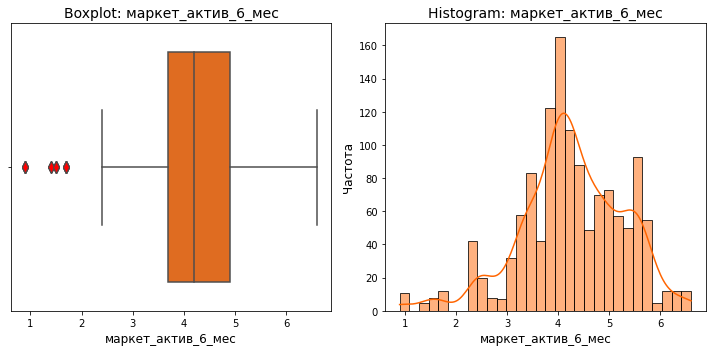

Столбец: маркет_актив_тек_мес
Количество выбросов: 631
    маркет_актив_тек_мес
0                      5
2                      3
3                      5
4                      3
6                      3
9                      5
11                     5
12                     3
18                     3
20                     5 



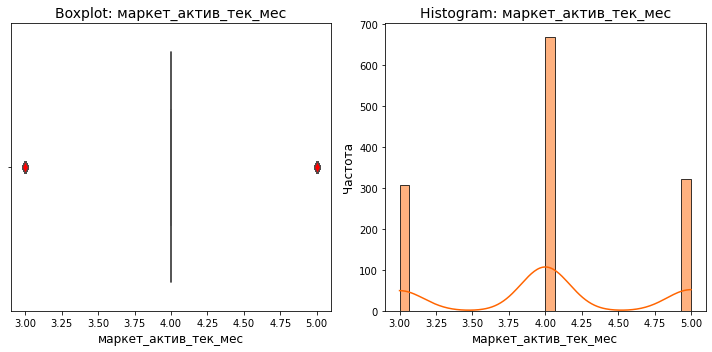

Столбец: длительность
Количество выбросов: 0


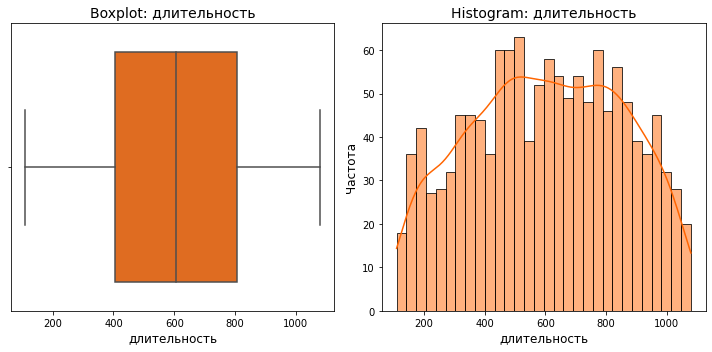

Столбец: акционные_покупки
Количество выбросов: 168
    акционные_покупки
1                0.75
3                0.99
4                0.94
14               0.74
16               0.98
17               0.95
25               0.90
26               0.98
27               0.89
28               0.98 



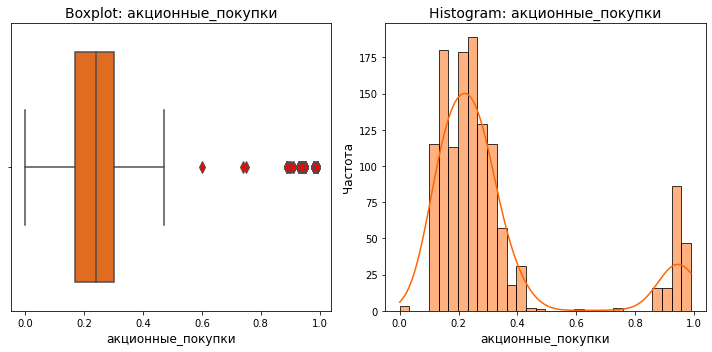

Столбец: средний_просмотр_категорий_за_визит
Количество выбросов: 0


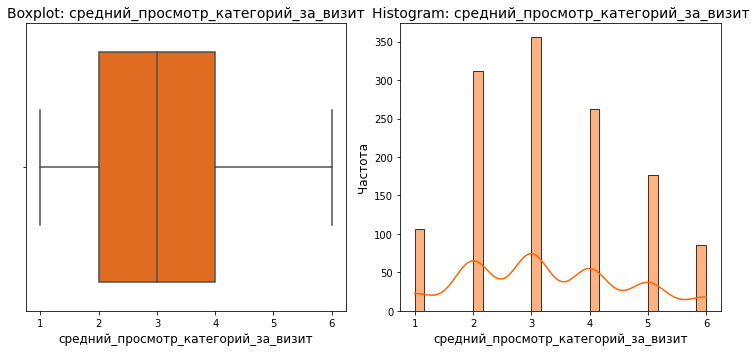

Столбец: неоплаченные_продукты_штук_квартал
Количество выбросов: 14
     неоплаченные_продукты_штук_квартал
72                                    9
73                                   10
117                                   9
118                                  10
176                                  10
186                                   9
204                                   9
216                                  10
246                                   9
251                                   9 



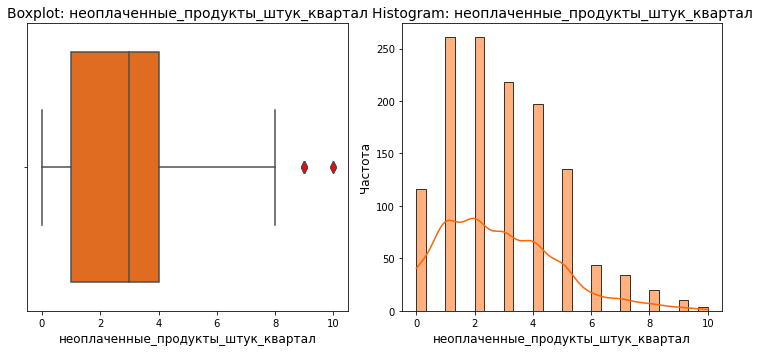

Столбец: ошибка_сервиса
Количество выбросов: 0


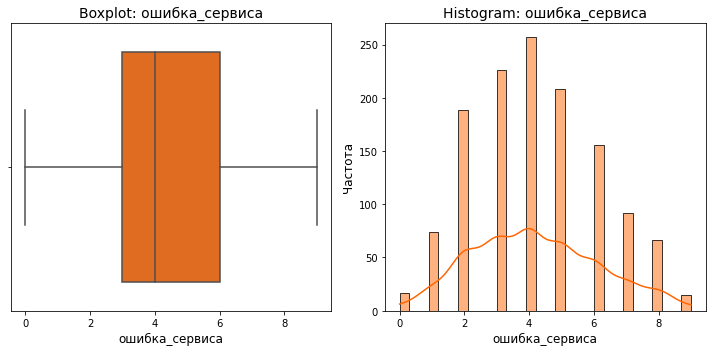

Столбец: страниц_за_визит
Количество выбросов: 0


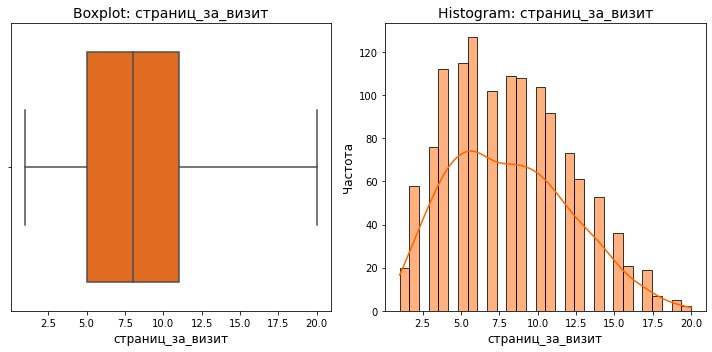

In [21]:
# Проверка числовых столбцов датасета "Поведение покупателей и коммуникации" на выбросы
numeric_columns = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'
]

for column in numeric_columns:
    analyze_column_with_outliers(market_file_df, column, color='#FF6501')

**Промежуточные выводы после анализа выбросов в датасете "Поведение покупателей и коммуникации":**

- **Обнаружение выбросов:**
    - **'маркет_актив_6_мес':** Обнаружено 36 выбросов, значения меньше 2.0. Это может быть связано с минимальным маркетинговым взаимодействием с клиентами;
    - **'маркет_актив_тек_мес':** Найден 631 выброс, значения распределены по краям (меньше 3 и больше 5). Однако это может отражать редкие, но реальные случаи;
    - **'акционные_покупки':** 168 выбросов в диапазоне 0.75–0.99. Эти значения могут быть связаны с активным реагированием клиентов на акции;
    - **'неоплаченные_продукты_штук_квартал':** 14 выбросов, значения ≥9. Это может свидетельствовать о нестандартном поведении клиентов или проблемах в использовании сайта.
---
- **Распределение значений:**
    - Столбцы 'акционные_покупки', 'маркет_актив\_6\_мес' и 'маркет_актив_тек_мес' имеют асимметричное распределение;
    - Столбец 'неоплаченные_продукты_штук_квартал' имеет редкие высокие значения, что требует дополнительного анализа.
---
- **Обработка выбросов:**
    - Выбросы не удаляются на этапе предобработки, так как они могут содержать важную информацию для дальнейшего анализа и моделирования;
    - На следующем этапе будет изучена их связь с целевым признаком и другими переменными.

**Обнаружение аномальных значений в датасете "Данные о выручке"**

Столбец: выручка
Количество выбросов: 175
    выручка
0       0.0
1    3293.1
2       0.0
9    6610.4
23   3263.0
28      0.0
29      0.0
34      0.0
35      0.0
69   6937.7 



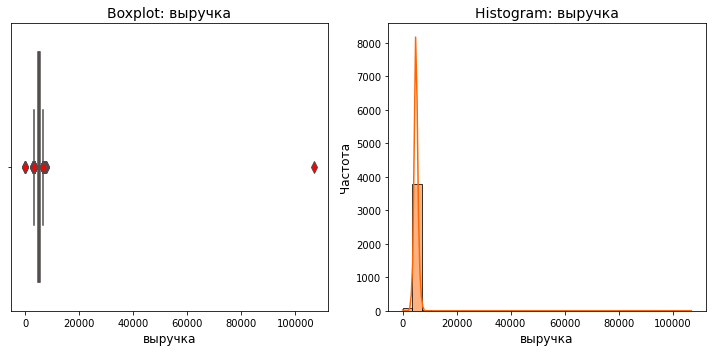

In [22]:
# Проверка столбца 'выручка' датасета "Данные о выручке" на выбросы
analyze_column_with_outliers(market_money_df, 'выручка', color='#FF6501')

In [23]:
# Проверка на дублирование id
duplicated_ids = market_money_df['id'].duplicated(keep=False)
duplicated_ids_count = market_money_df[duplicated_ids]['id'].value_counts()

print(f"Количество уникальных id с дубликатами: {duplicated_ids_count.count()}")
print(f"Примеры id с дубликатами:\n{duplicated_ids_count.head()}")

Количество уникальных id с дубликатами: 1300
Примеры id с дубликатами:
215349    3
215756    3
215792    3
215790    3
215788    3
Name: id, dtype: int64


**Промежуточные выводы после анализа выбросов в датасете "Данные о выручке":**

- Столбец **'выручка'**:
  - **Обнаружено 175 выбросов**:
    - Среди выбросов присутствуют значения 0.0, что, вероятно, связано с отсутствием покупок у некоторых клиентов за указанный период;
    - Также обнаружено значение значительно превышающее третий квартиль (**106862.2**). С одной стороны, это значение может свидетельствовать о высокой покупательской активности клиента. С другой стороны, это значение может быть ошибкой ввода или сбоем. На данном этапе решено оставить выброс для анализа и визуализации, но будет проведён дополнительный исследовательский анализ этого значения.
  - Гистограмма показывает, что распределение данных сильно скошено в сторону малых значений, большинство клиентов имеют низкую выручку.
---
- **Дубликаты 'id'**:
  - Каждый id в таблице представлен трижды, так как данные представлены за три временных периода (препредыдущий, предыдущий, текущий месяц). Это подтверждает, что строки не являются дубликатами, а описывают активность одного клиента за разные периоды.
---
- **Обработка выбросов**:
  - Выбросы пока не обрабатываются, так как они могут содержать важную информацию, особенно для анализа клиентов с высокой активностью;
  - Значения 0.0 оставлены без изменений, так как они могут быть корректными и указывать на отсутствие покупок.

**Обнаружение аномальных значений в датасете "Данные о времени на сайте"**

Столбец: минут
Количество выбросов: 0


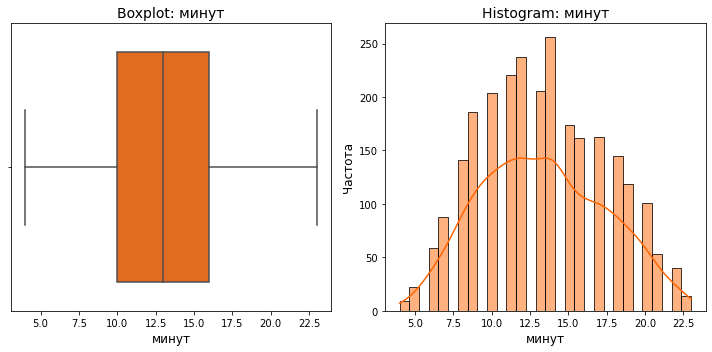

In [24]:
# Проверка столбца 'минут' датасета "Данные о времени на сайте" на выбросы
analyze_column_with_outliers(market_time_df, 'минут', color='#FF6501')

**Промежуточные выводы после анализа выбросов в датасете "Данные о времени на сайте":**
- В столбце **'минут'** выбросов не обнаружено;
- Распределение значений выглядит корректным и не требует дополнительной обработки;
- Данные в этом столбце можно использовать для дальнейшего анализа без изменений.

**Обнаружение аномальных значений в датасете "Данные о прибыли"**

Столбец: прибыль
Количество выбросов: 12
     прибыль
0       0.98
52      6.73
53      7.43
182     1.06
215     6.88
637     6.78
774     0.86
817     7.02
920     6.81
938     1.08 



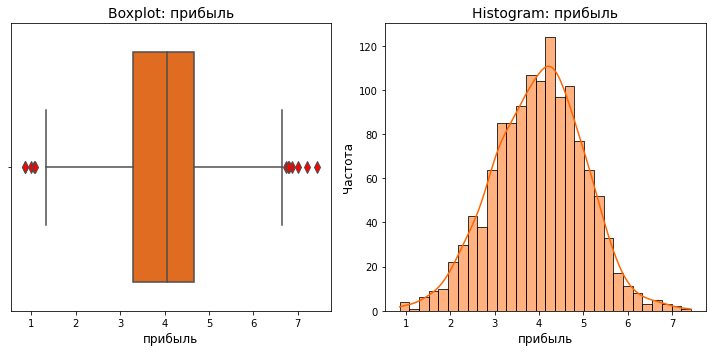

In [25]:
# Проверка столбца 'прибыль' датасета "Данные о прибыли" на выбросы
analyze_column_with_outliers(money_df, 'прибыль', color='#FF6501')

**Промежуточные выводы после анализа выбросов в датасете "Данные о прибыли":**
- В столбце **'прибыль'** обнаружено **12 выбросов**, которые находятся как ниже нижней границы, так и выше верхней границы нормального диапазона;
- Выбросы представляют собой значения, которые значительно отличаются от основной массы данных;
- Гистограмма показывает, что распределение данных в столбце близко к нормальному, однако выбросы расположены по краям;
- На данном этапе выбросы пока не удаляем, они будут дополнительно проанализированы в процессе исследования данных или моделирования.

### Промежуточные выводы после предобработки данных

**Проверка и обработка пропущенных значений и явных дубликатов:**
- **Пропущенные значения**:
  - Во всех таблицах пропусков не обнаружено, данные полностью заполнены;
  - На данном этапе отсутствует необходимость обработки пропусков.

- **Явные дубликаты**:
  - Явных дубликатов в таблицах не найдено;
  - Данные готовы для дальнейшего анализа без удаления дубликатов.
---
**Приведение текстовых значений к единому регистру:**
- Все текстовые значения во всех таблицах приведены к нижнему регистру для унификации;
- Это упростит обработку текстовых данных, особенно при группировках и фильтрациях.
---
**Обработка неявных дубликатов и исправление опечаток:**
- Все опечатки и неявные дубликаты устранены, что улучшает качество данных и их пригодность для дальнейшего анализа.
---
**Обнаружение и обработка аномальных значений:**
- **Датасет "Поведение покупателей и коммуникации"**:
  - Аномалии обнаружены в столбцах: 'маркет_актив\_6\_мес' (36 выбросов), 'маркет_актив_тек_мес' (631 выброс), 'акционные_покупки' (168 выбросов), 'неоплаченные_продукты_штук_квартал' (14 выбросов).
  - Выбросы в данных оставлены без изменений для дальнейшего анализа.

- **Датасет "Данные о выручке"**:
  - Обнаружено 175 выбросов, включая значения 0.0, которые могут быть корректными (отсутствие покупок).
  - Выбросы не обрабатывались, чтобы сохранить важную информацию для анализа.

- **Датасет "Данные о времени на сайте"**:
  - Выбросов в столбце 'минут' не обнаружено, распределение выглядит корректным.

- **Датасет "Данные о прибыли"**:
  - Обнаружено 12 выбросов, значения находятся как ниже минимального, так и выше максимального нормального диапазона;
  - Выбросы оставлены без изменений для дальнейшего изучения.
---
**Общие выводы:**
На данном этапе предобработка данных завершена:
- Данные очищены от опечаток, унифицированы и готовы для исследования;
- Аномальные значения выявлены, но не обработаны, так как они могут содержать полезную информацию для дальнейшего анализа и моделирования.

## Исследовательский анализ данных

### Анализ клиента с самым большим значением выручки

In [26]:
# Просмотр самых больших значений из столбца "выручка"
print("Топ 10 самых больших значений в столбце 'выручка':")
print(market_money_df.nlargest(10, 'выручка')[['id', 'выручка']])

Топ 10 самых больших значений в столбце 'выручка':
          id   выручка
98    215380  106862.2
435   215493    7799.4
262   215435    7605.3
1481  215841    7557.0
2388  216144    7547.8
566   215536    7467.9
2266  216103    7410.0
1003  215682    7401.6
1632  215892    7401.6
1573  215872    7374.0


In [27]:
# Фильтрация по id клиента с самым большим значением выручки
top_client_id = 215380

# Фильтрация строк с данным клиентом
top_client_data = market_money_df[market_money_df['id'] == top_client_id]

# Вывод данных по этому клиенту
print(f"Данные клиента с id = {top_client_id}:")
print(top_client_data)

Данные клиента с id = 215380:
        id               период   выручка
96  215380  препредыдущий_месяц    5051.0
97  215380     предыдущий_месяц    6077.0
98  215380        текущий_месяц  106862.2


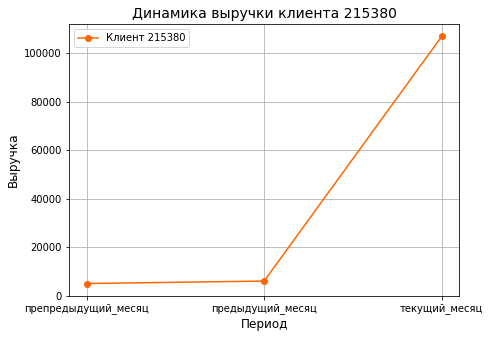

In [28]:
# Построение графика выручки клиента по периодам
plt.figure(figsize=(7, 5))
plt.plot(top_client_data['период'], top_client_data['выручка'], color='#FF6501', marker='o', label=f'Клиент {top_client_id}')
plt.title(f'Динамика выручки клиента {top_client_id}', fontsize=14)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.legend()
plt.grid()
plt.show()

In [29]:
# Данные из market_file_df
client_marketing_data = market_file_df[market_file_df['id'] == top_client_id]
print(f"Данные клиента из таблицы 'market_file_df':")
display(client_marketing_data)

# Данные из market_time_df
client_time_data = market_time_df[market_time_df['id'] == top_client_id]
print(f"Данные клиента из таблицы 'market_time_df':")
display(client_time_data)

Данные клиента из таблицы 'market_file_df':


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,снизилась,премиум,нет,1.7,4,637,0.94,техника для красоты и здоровья,3,2,4,7


Данные клиента из таблицы 'market_time_df':


,id,период,минут
64,215380,предыдущий_месяц,12
65,215380,текущий_месяц,14


In [30]:
# Сравнение с другими клиентами с высокой выручкой
top_clients = market_money_df.nlargest(10, 'выручка')[['id', 'выручка']]
top_clients_ids = top_clients['id'].tolist()

# Данные для этих клиентов
top_clients_data = market_file_df[market_file_df['id'].isin(top_clients_ids)]
print("Данные для клиентов с высокой выручкой из market_file_df:")
display(top_clients_data)

Данные для клиентов с высокой выручкой из market_file_df:


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,снизилась,премиум,нет,1.7,4,637,0.94,техника для красоты и здоровья,3,2,4,7
87,215435,снизилась,премиум,да,4.8,4,875,0.35,товары для детей,2,2,5,9
145,215493,снизилась,стандарт,да,4.0,5,881,0.99,кухонная посуда,3,5,6,5
188,215536,снизилась,стандарт,нет,3.8,3,898,0.40,кухонная посуда,3,6,2,5
334,215682,снизилась,премиум,да,5.8,3,724,0.17,косметика и аксессуары,1,1,3,6
493,215841,снизилась,стандарт,да,6.3,4,320,0.12,мелкая бытовая техника и электроника,5,4,4,10
524,215872,прежний уровень,стандарт,нет,5.1,4,490,0.17,домашний текстиль,3,4,5,14
544,215892,прежний уровень,стандарт,да,5.8,4,442,0.17,мелкая бытовая техника и электроника,3,3,3,6
755,216103,прежний уровень,стандарт,нет,5.7,4,528,0.17,мелкая бытовая техника и электроника,3,2,3,8
796,216144,прежний уровень,стандарт,да,4.8,4,541,0.29,мелкая бытовая техника и электроника,3,5,5,9


In [31]:
# Вычисление медианы выручки за текущий месяц
current_month_median = market_money_df[market_money_df['период'] == 'текущий_месяц']['выручка'].median().round(2)
print(f"Медиана выручки за текущий месяц: {current_month_median}")

Медиана выручки за текущий месяц: 5179.95


In [32]:
# Приведение выброса к медиане
market_money_df.loc[
    (market_money_df['id'] == top_client_id) & (market_money_df['период'] == 'текущий_месяц'),
    'выручка'
] = current_month_median

# Проверка результата
print("Обновленные данные клиента:")
print(market_money_df[market_money_df['id'] == top_client_id])

Обновленные данные клиента:
        id               период  выручка
96  215380  препредыдущий_месяц  5051.00
97  215380     предыдущий_месяц  6077.00
98  215380        текущий_месяц  5179.95


**Промежуточные выводы по клиенту с самым большим значением выручки:**

**Поведение клиента:**
   - Клиент с ID '215380' имеет следующие данные о выручке:
     - **Препредыдущий месяц:** 5051.0;
     - **Предыдущий месяц:** 6077.0;
     - **Текущий месяц:** 106862.2.
   - Резкий скачок выручки в текущем месяце не соответствует покупательской активности за предыдущие периоды.
---
**Маркетинговая активность:**
   - В таблице маркетинговых данных ('market_file_df'):
   - **Активность снизилась,** что не коррелирует с резким ростом выручки;
   - Клиент использует **премиум-сервис** и совершает покупки из категории "Техника для красоты и здоровья";
   - Средний просмотр категорий за визит составляет всего 3 страницы, а среднее время на сайте — 12–14 минут.
   - Эти показатели типичны для менее активных клиентов.
---
**Сравнение с другими клиентами:**
   - Среди клиентов с высокой выручкой большинство демонстрируют стабильное поведение с выручкой менее 8000;
   - Клиенты с похожей выручкой в течение трех месяцев имеют более высокую маркетинговую активность и более длительное время на сайте.
---
**Общие выводы:**
   - Значение выручки 106862.2 является аномалией и не соответствует целям проекта, которые фокусируются на удержании постоянных клиентов с предсказуемым поведением;
   - Возможно, значение связано с ошибкой в данных или единичной покупкой дорогостоящего товара, что не является целью для удержания.
---
**Решение по обработке выброса:**
   - Для устранения влияния аномалии на дальнейший анализ и модели было принято решение привести значение выручки в текущем месяце для клиента с ID 215380 к медиане выручки за текущий месяц (5179.95).

### Изучение клиентов с покупательской активностью не менее трёх месяцев

In [33]:
# Отбор активных клиентов с выручкой > 0 для каждого из 3 периодов
active_clients = market_money_df.groupby('id').filter(
    lambda x: (x['выручка'] > 0).sum() == 3
)

print(f"Количество активных клиентов: {active_clients['id'].nunique()}")

Количество активных клиентов: 1297


In [34]:
# Список уникальных активных клиентов
active_client_ids = active_clients['id'].unique()

# Фильтрация других таблиц по активным клиентам
active_market_file_df = market_file_df[market_file_df['id'].isin(active_client_ids)]
active_market_time_df = market_time_df[market_time_df['id'].isin(active_client_ids)]
active_money_df = money_df[money_df['id'].isin(active_client_ids)]

In [35]:
# Исследование распределений
def plot_distributions(df, columns, title_prefix=""):
    for column in columns:
        plt.figure(figsize=(10, 5))
        
        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[column], color='#FF6501', flierprops={"markerfacecolor": "red", "markersize": 8})
        plt.title(f'{title_prefix}Boxplot: {column}', fontsize=14)
        plt.xlabel(column, fontsize=12)
        
        # Histogram
        plt.subplot(1, 2, 2)
        sns.histplot(df[column], bins=30, kde=True, color='#FF6501')
        plt.title(f'{title_prefix}Histogram: {column}', fontsize=14)
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Частота', fontsize=12)
        
        plt.tight_layout()
        plt.show()

**Исследование распределения выручки активных клиентов**

In [36]:
# Изучение выручки активных клиентов
active_clients_stats = active_clients[['выручка']].describe().round(2)
active_clients_styled_stats = (
    active_clients_stats
    .transpose()
    .style
    .set_caption("Статистика по колонке")
    .format("{:.2f}")
)
display(active_clients_styled_stats)

,count,mean,std,min,25%,50%,75%,max
выручка,3891.00,5007.59,679.15,2758.70,4592.00,4959.00,5363.00,7799.40


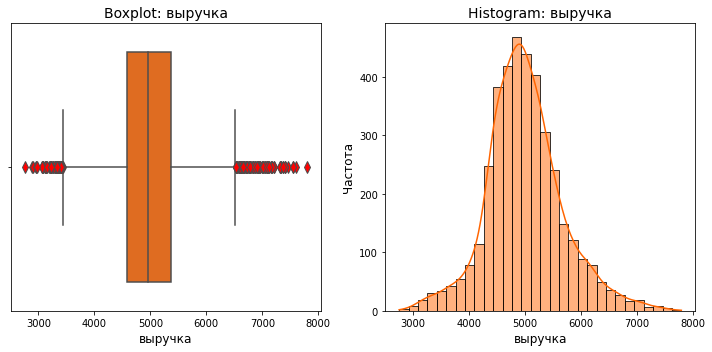

In [37]:
# Изучение распределения выручки активных клиентов
plot_distributions(active_clients, ['выручка'])

**Промежуточные выводы по выручке активных клиентов:**

- Средняя выручка — 5007.59, медиана — 4959.00, стандартное отклонение — 679.15;
- Выручка варьируется от 2758.70 до 7799.40, выбросы в данных расположены как с нижней стороны, так и с верхней;
- Распределение данных близко к нормальному, но с небольшим смещением влево.

**Исследование распределения прибыли активных клиентов**

In [38]:
# Изучение прибыли активных клиентов
active_money_stats = active_money_df[['прибыль']].describe().round(2)
active_money_styled_stats = (
    active_money_stats
    .transpose()
    .style
    .set_caption("Статистика по колонке")
    .format("{:.2f}")
)
display(active_money_styled_stats)

,count,mean,std,min,25%,50%,75%,max
прибыль,1297.00,4.00,1.01,0.86,3.30,4.04,4.67,7.43


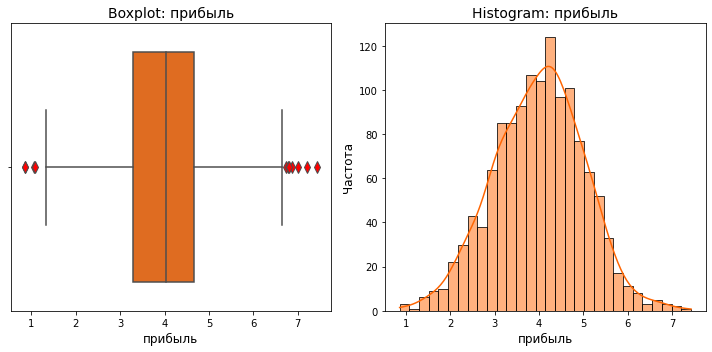

In [39]:
# Изучение распределения прибыли активных клиентов
plot_distributions(active_money_df, ['прибыль'])

**Промежуточные выводы по прибыли активных клиентов:**

- Средняя прибыль — 4.00, медиана — 4.04, стандартное отклонение — 1.01;
- Boxplot показывает наличие выбросов в крайних значениях (вверху и внизу);
- Гистограмма указывает на распределение, близкое к нормальному, с лёгким смещением вправо.
- Данные по прибыли активных клиентов в целом имеют умеренно широкий разброс.

**Изучение колонок 'маркет_актив\_6\_мес', 'маркет_актив_тек_мес', 'акционные_покупки'**

In [40]:
# Изучение колонок 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки'
active_marketing_stats = (
    active_market_file_df[
        ['маркет_актив_6_мес', 
         'маркет_актив_тек_мес', 
         'акционные_покупки']
    ]
    .describe()
    .round(2)
)
active_marketing_styled_stats = (
    active_marketing_stats
    .transpose()
    .style
    .set_caption("Статистика по колонкам")
    .format("{:.2f}")
)
display(active_marketing_styled_stats)

,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,1297.00,4.25,1.02,0.90,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1297.00,4.01,0.70,3.00,4.00,4.00,4.00,5.00
акционные_покупки,1297.00,0.32,0.25,0.11,0.17,0.24,0.30,0.99


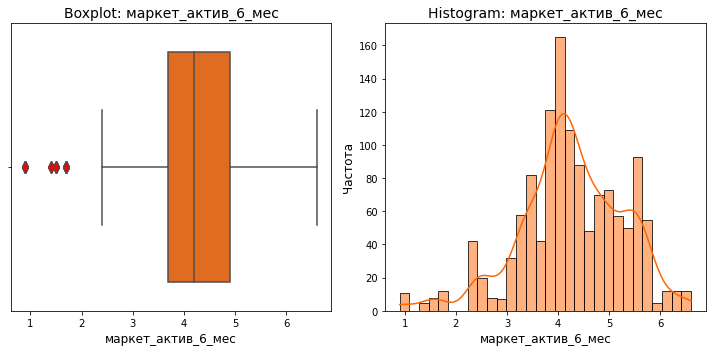

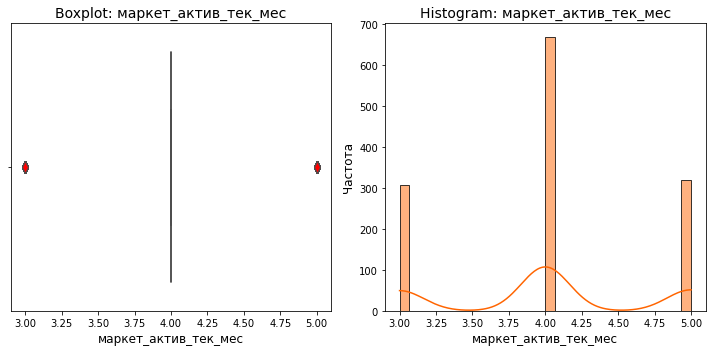

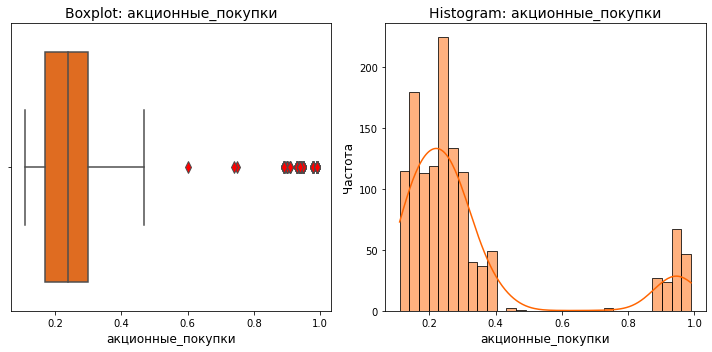

In [41]:
# Изучение распределения колонок 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки'
plot_distributions(active_market_file_df, ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки'])

**Промежуточные выводы по колонкам 'маркет_актив\_6\_мес', 'маркет_актив_тек_мес', 'акционные_покупки':**

**'маркет_актив\_6\_мес':**
- Среднее значение — 4.25, медиана — 4.20, стандартное отклонение — 1.02;
- Диапазон значений от 0.90 до 6.60, выбросы присутствуют с нижней стороны (< 3);
- Распределение близко к нормальному, с небольшим смещением вправо.

**'маркет_актив_тек_мес':**
- Среднее значение — 4.01, медиана — 4.00, стандартное отклонение — 0.70;
- Гистограмма показывает дискретное распределение, с основными значениями — 3.00, 4.00 и 5.00.

**'акционные_покупки':**
- Среднее значение — 0.32, медиана — 0.24, стандартное отклонение — 0.25;
- Распределение асимметрично, с сильным левым смещением.

**Изучение колонок 'длительность', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит'**

In [42]:
# Изучение колонок 'длительность', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит'
active_surfing_stats = (
    active_market_file_df[
        ['длительность', 
         'средний_просмотр_категорий_за_визит', 
         'страниц_за_визит']
    ]
    .describe()
    .round(2)
)
active_surfing_styled_stats = (
    active_surfing_stats
    .transpose()
    .style
    .set_caption("Статистика по колонкам")
    .format("{:.2f}")
)
display(active_surfing_styled_stats)

,count,mean,std,min,25%,50%,75%,max
длительность,1297.00,602.99,249.10,121.00,410.00,607.00,806.00,1079.00
средний_просмотр_категорий_за_визит,1297.00,3.27,1.35,1.00,2.00,3.00,4.00,6.00
страниц_за_визит,1297.00,8.19,3.98,1.00,5.00,8.00,11.00,20.00


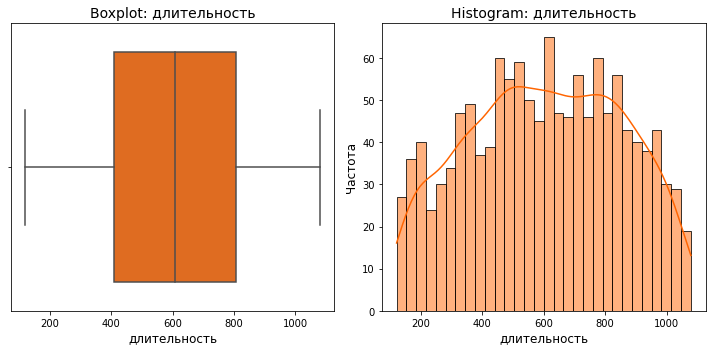

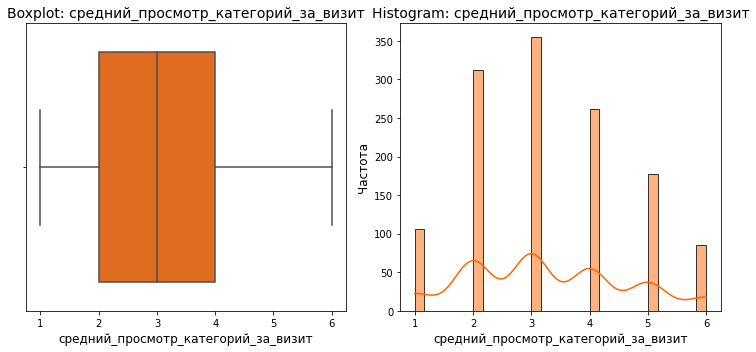

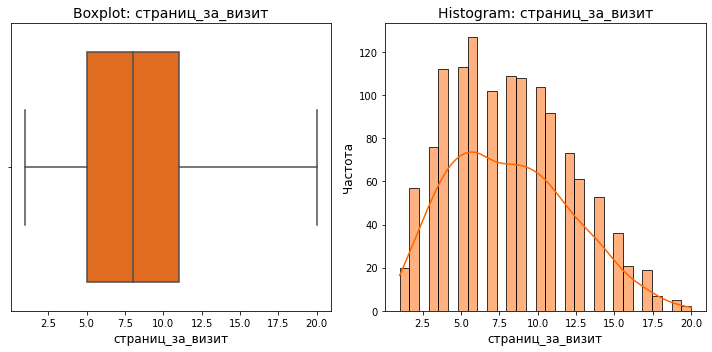

In [43]:
# Изучение распределения колонок 'длительность', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит'
plot_distributions(active_market_file_df, ['длительность', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит'])

**Промежуточные выводы по колонкам 'длительность', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит':**

**'длительность':**
- Среднее значение — 602.99, медиана — 607.00, стандартное отклонение — 249.10;
- Распределение близко к нормальному, с небольшим смещением вправо. Выбросов не выявлено.

**'средний_просмотр_категорий_за_визит':**
- Среднее значение — 3.27, медиана — 3.00, стандартное отклонение — 1.35;
- Дискретное распределение с пиками на целых числах (2, 3, 4). Выбросов не выявлено.

**'страниц_за_визит':**
- Среднее значение — 8.19, медиана — 8.00, стандартное отклонение — 3.98;
- Распределение стремится влево.

**Изучение колонок 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса'**

In [44]:
# Изучение колонок 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса'
active_service_stats = (
    active_market_file_df[
        ['неоплаченные_продукты_штук_квартал', 
         'ошибка_сервиса']
    ]
    .describe()
    .round(2)
)
active_service_styled_stats = (
    active_service_stats
    .transpose()
    .style
    .set_caption("Статистика по колонкам")
    .format("{:.2f}")
)
display(active_service_styled_stats)

,count,mean,std,min,25%,50%,75%,max
неоплаченные_продукты_штук_квартал,1297.00,2.84,1.97,0.00,1.00,3.00,4.00,10.00
ошибка_сервиса,1297.00,4.18,1.95,0.00,3.00,4.00,6.00,9.00


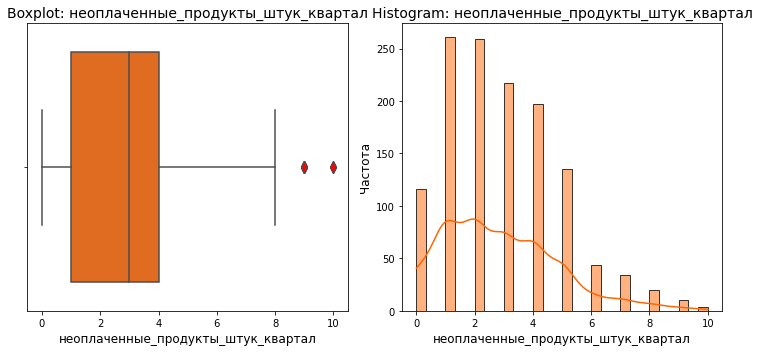

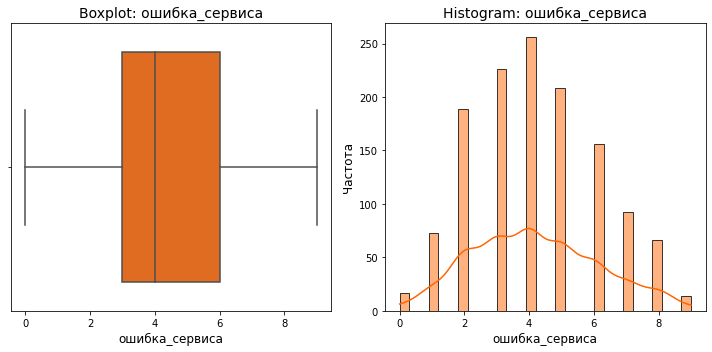

In [45]:
# Изучение распределения колонок 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса'
plot_distributions(active_market_file_df, ['неоплаченные_продукты_штук_квартал', 'ошибка_сервиса'])

**Промежуточные выводы по колонкам 'неоплаченные_продукты_штук_квартал' и 'ошибка_сервиса':**

**'неоплаченные_продукты_штук_квартал':**
- Среднее значение — 2.84, медиана — 3.00, стандартное отклонение — 1.97;
- Диапазон значений от 0 до 10, выбросы наблюдаются выше 8;
- Распределение скошено влево, большая часть значений сосредоточена в диапазоне 2–4.

**'ошибка_сервиса':**
- Среднее значение — 4.18, медиана — 4.00, стандартное отклонение — 1.95;
- Распределение ближе к нормальному, но имеет легкое смещение влево.

**Изучение распределения времени, проведённого активными клиентами на сайте**

,count,mean,std,min,25%,50%,75%,max
период,,,,,,,,
предыдущий_месяц,1297.00,13.47,3.94,5.00,11.00,13.00,17.00,23.00
текущий_месяц,1297.00,13.21,4.22,4.00,10.00,13.00,16.00,23.00


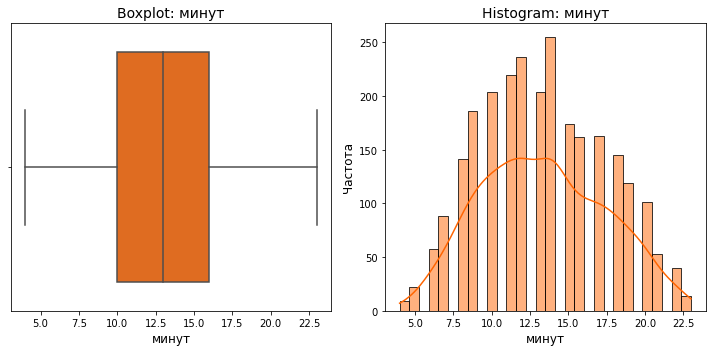

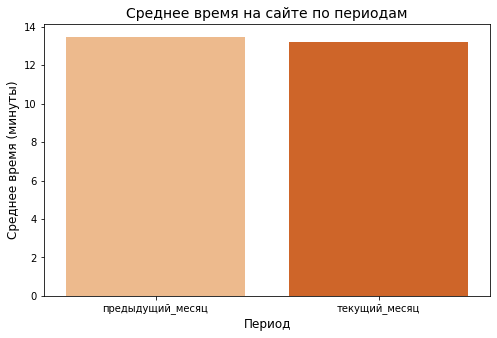

In [46]:
# Описательная статистика по времени на сайте
time_stats = active_market_time_df.groupby('период')['минут'].describe().round(2)
time_styled_stats = (
    time_stats
    .style
    .set_caption("Статистика времени на сайте по периодам")
    .format("{:.2f}")
)
display(time_styled_stats)

# Построение графиков распределения
plot_distributions(active_market_time_df, ['минут'])

# Сравнение периодов
mean_minutes_by_period = (
    active_market_time_df.groupby('период')['минут'].mean().reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(data=mean_minutes_by_period, x='период', y='минут', palette='Oranges')
plt.title("Среднее время на сайте по периодам", fontsize=14)
plt.xlabel("Период", fontsize=12)
plt.ylabel("Среднее время (минуты)", fontsize=12)
plt.show()

**Промежуточные выводы по изучению распределения времени, проведённого активными клиентами на сайте**

**Общая статистика:**
- Среднее время на сайте в предыдущем месяце — 13.47 минут, в текущем месяце — 13.21 минут;
- Медиана для обоих периодов — 13 минут.
---
**Распределение:**
- Временные показатели варьируются от 4–5 минут (минимум) до 23 минут (максимум) в обоих периодах;
- Распределение времени на сайте близко к нормальному с небольшим сдвигом влево.
---
**Сравнение периодов:**
- Незначительное снижение среднего времени на сайте в текущем месяце;
- Подобные результаты могут указывать на стабильность активности клиентов по времени, проведённому на сайте.

**Анализ распределения покупательской активности**

In [47]:
# Анализ категориальных данных с круговым графиком
def plot_categorical_distributions(df, column, title):
    plt.figure(figsize=(10, 5))
    data = df[column].value_counts()
    plt.pie(
        data,
        labels=data.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('Oranges', len(data))
    )
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

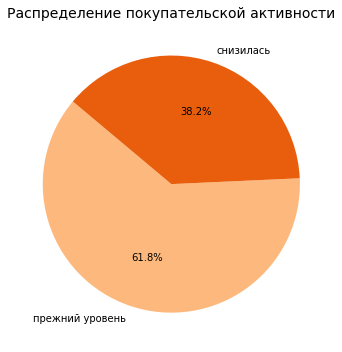

In [48]:
# Покупательская активность
plot_categorical_distributions(active_market_file_df, 'покупательская_активность', 'Распределение покупательской активности')

**Промежуточные выводы по анализу распределения покупательской активности:**

- Распределение покупательской активности наглядно показало, что:
  - Большинство клиентов находится на прежнем уровне активности;
  - Значительная доля демонстрирует снижение активности.

**Анализ распределения типов сервиса**

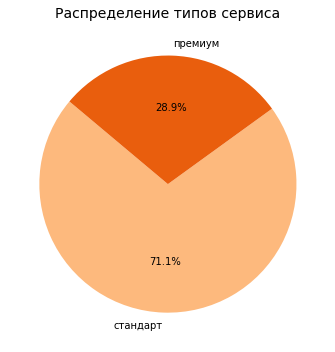

In [49]:
# Тип сервиса
plot_categorical_distributions(active_market_file_df, 'тип_сервиса', 'Распределение типов сервиса')

**Промежуточные выводы по анализу распределения типов сервиса:**

- Большинство клиентов (71.1%) используют стандартный сервис;
- Лишь 28.9% клиентов предпочитают премиум сервис;
- Стандартный сервис является основным выбором клиентов, что может быть связано с его доступностью и соответствием потребностям большинства.

**Анализ распределения согласия клиентов на получение дополнительных предложений о товарах**

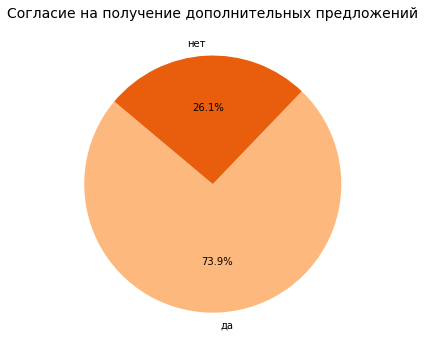

In [50]:
# Pаспределение согласия на получение дополнительных предложений
plot_categorical_distributions(active_market_file_df, 'разрешить_сообщать', 'Согласие на получение дополнительных предложений')

**Промежуточные выводы по анализу распределения согласия на получение дополнительных предложений:**

- Большинство клиентов (73.9%) дали согласие на получение дополнительных предложений о товарах;
- Лишь 26.1% клиентов отказались от таких уведомлений.

**Анализ распределения популярных категорий товаров среди активных клиентов**

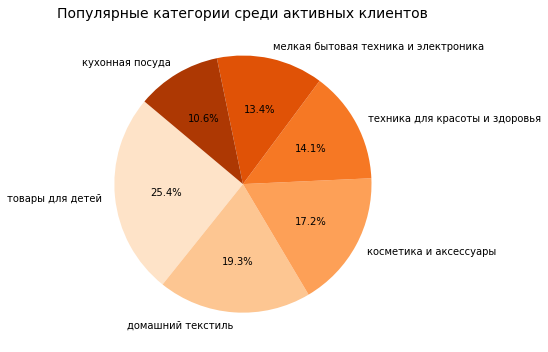

In [51]:
# Популярные категории
plot_categorical_distributions(active_market_file_df, 'популярная_категория', 'Популярные категории среди активных клиентов')

**Промежуточные выводы по анализу распределения популярных категорий товаров среди активных клиентов:**

- Самой популярной категорией товаров являются **товары для детей** (25.4%);
- Значительная доля также приходится на категории **домашний текстиль** (19.3%) и **косметика и аксессуары** (17.2%);
- Меньшую долю составляют **техника для красоты и здоровья** (14.1%), **мелкая бытовая техника и электроника** (13.4%) и **кухонная посуда** (10.6%).

### Промежуточные выводы по исследовательскому анализу данных

**Выручка и прибыль:**
- Средняя выручка клиентов — 5007.59, медиана — 4959.00, выбросы наблюдаются в крайних значениях;
- Прибыль клиентов в среднем составляет 4.00, распределение близко к нормальному.
---
**Маркетинговая активность:**
- Активность за 6 месяцев: среднее значение — 4.25, активность за текущий месяц — 4.01;
- Покупки по акциям в среднем составляют 0.32, распределение асимметрично влево.
---
**Время клиентов на сайте:**
- Среднее время на сайте стабильно (13 минут за оба месяца), с небольшим снижением в текущем месяце;
- Распределение времени близко к нормальному.
---
**Покупательская активность:**
- Большинство клиентов сохраняют уровень активности, но значительная доля демонстрирует снижение.
---
**Тип сервиса:**
- 71.1% клиентов используют стандартный сервис, только 28.9% предпочитают премиум.
---
**Популярные категории товаров:**
- Лидирует категория "товары для детей" (25.4%);
- Также популярны "домашний текстиль" (19.3%) и "косметика и аксессуары" (17.2%).

## Объединение таблиц

In [52]:
# Поворачиваем market_money_df (выручка) для разделения по периодам
market_money_pivot = market_money_df.pivot(index='id', columns='период', values='выручка').reset_index()
market_money_pivot.columns = ['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

# Поворачиваем market_time_df (время) для разделения по периодам
market_time_pivot = market_time_df.pivot(index='id', columns='период', values='минут').reset_index()
market_time_pivot.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']

# Объединяем market_file_df, market_money_pivot и market_time_pivot
merged_df = (
    market_file_df
    .merge(market_money_pivot, on='id', how='left')
    .merge(market_time_pivot, on='id', how='left')
)
data_overview(merged_df, "Объединённая таблица")

Обзор данных: Объединённая таблица
Размер данных: 1300 строк и 18 столбцов.

Первые 3 строки данных:


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13



Общая информация о данных:
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_к

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18,4936.92,4825.21,5236.74,13.47,13.20
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98,739.60,405.98,835.15,3.93,4.22
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,2758.70,5.00,4.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00,4496.75,4583.00,4706.05,11.00,10.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00,5005.00,4809.00,5179.77,13.00,13.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00,5405.62,5053.50,5759.28,17.00,16.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00,6869.50,5663.00,7799.40,23.00,23.00



Проверка явных дубликатов
---------------------------------------
Количество явных дубликатов: 0

Проверка пропусков
---------------------------------------


,nan_qty,nan_percent
id,0,0.00%
покупательская_активность,0,0.00%
минут_предыдущий_месяц,0,0.00%
выручка_текущий_месяц,0,0.00%
выручка_предыдущий_месяц,0,0.00%
выручка_препредыдущий_месяц,0,0.00%
страниц_за_визит,0,0.00%
ошибка_сервиса,0,0.00%
неоплаченные_продукты_штук_квартал,0,0.00%
средний_просмотр_категорий_за_визит,0,0.00%


### Промежуточные выводы после объединения таблиц

- **Цель объединения таблиц:** 
  - Создание единого датафрейма для дальнейшего анализа, включающего данные о маркетинговой активности, выручке и времени, проведённом на сайте, с разбивкой по периодам.
---
- **Структура объединённой таблицы:**
  - Итоговая таблица содержит 1300 строк и 18 столбцов;
  - Колонки охватывают метрики маркетинговой активности, выручки, времени на сайте, а также дополнительные характеристики клиентов.
---
- **Распределение данных:**
  - В таблице представлены данные по трём периодам для выручки: 'препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц';
  - Для времени на сайте данные представлены по двум периодам: 'предыдущий_месяц' и 'текущий_месяц'.

## Корреляционный анализ

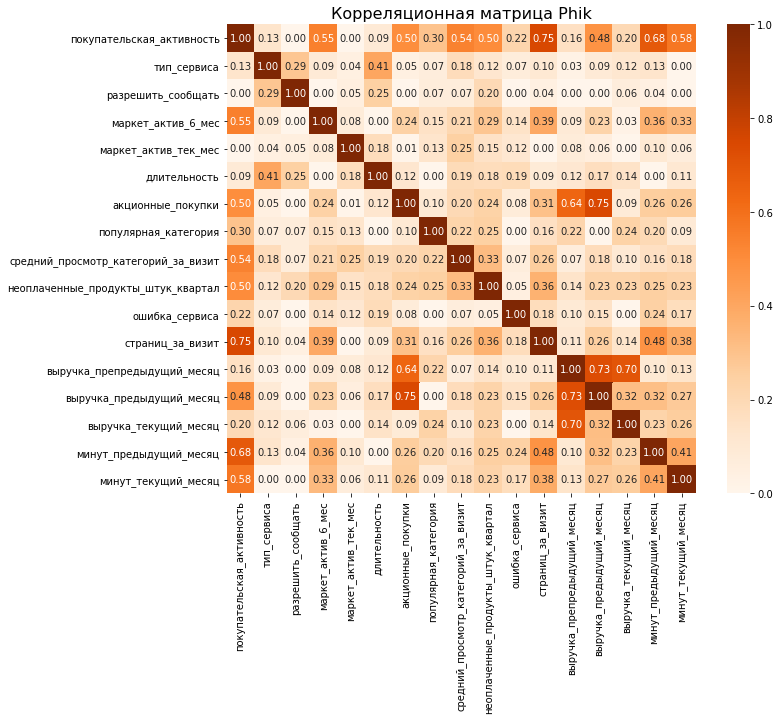

In [53]:
# Убираем колонку id
merged_df_for_corr = merged_df.drop(columns=['id'])

# Задаём количественные столбцы
interval_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит',
    'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц'
]

# Вычисление корреляционной матрицы
phik_corr_matrix = merged_df_for_corr.phik_matrix(interval_cols=interval_cols)

# Визуализация корреляционной матрицы с указанием цветовой схемы
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr_matrix, 
            annot=True,
            fmt=".2f",
            cmap="Oranges",
            cbar=True,
            square=True)
plt.title("Корреляционная матрица Phik", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Промежуточные выводы по корреляционному анализу

**Признаки с высокой корреляцией:**
- Сильная положительная корреляция наблюдается между:
  - Количеством просмотренных страниц за визит и покупательской активностью (коэффициент 0.75);
  - Количеством акционных покупок и выручкой за предыдущий месяц (коэффициент 0.75);
  - Выручкой за предыдущие периоды (коэффициенты 0.7–0.73);
  - Временем, проведённым на сайте за предыдущий и текущий месяцы, и покупательской активностью (коэффициенты 0.68–0.58).
---
**Проблемы мультиколлинеарности:**
   - Выручка за разные периоды (препредыдущий, предыдущий, текущий месяцы) демонстрирует высокую корреляцию между собой (коэффициенты: 0.7–0.73).
   - Количество страниц за визит и время на сайте (а также время за текущий месяц и предыдущий: 0.58–0.68) достаточно сильно коррелируют (коэффициенты: 0.48–0.38).
---
**Решение по устранению мультиколлинеарности:**
- Несмотря на наличие корреляции между некоторыми признаками, решено не удалять признаки для устранения мультиколлинеарности, так как все они имеют потенциальную значимость для построения модели: выручка за периоды важна для понимания финансового поведения клиентов и прогнозирования их активности; признаки, связанные с временем и количеством просмотренных страниц, также важны для анализа пользовательского поведения.

## Моделирование

In [54]:
# Параметры
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разделение данных
X = merged_df.drop(['покупательская_активность'], axis=1)
y = merged_df['покупательская_активность'].map({'снизилась': 1, 'прежний уровень': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Разделение признаков
cat_features = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_features = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'средний_просмотр_категорий_за_визит', 'акционные_покупки',
    'страниц_за_визит', 'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
    'минут_предыдущий_месяц', 'минут_текущий_месяц'
]

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='нет')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Пайплайн для числовых признаков
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', 'passthrough')
])

# Общий трансформер
preprocessor = ColumnTransformer([
    ('cat_ohe', cat_pipeline, cat_features),
    ('num', num_pipeline, num_features)
])

# Итоговый пайплайн
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
    ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'))
])

# Параметры для гиперпараметрической оптимизации
param_grid = [
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'model__C': np.logspace(-3, 3, 15),
        'feature_selection__k': [5, 8, 10],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(3, 15),
        'feature_selection__k': [5, 8, 10],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(3, 15),
        'model__min_samples_split': range(2, 10),
        'feature_selection__k': [5, 8, 10],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__C': np.logspace(-4, 3, 20),
        'model__kernel': ['linear', 'rbf'],
        'feature_selection__k': [5, 8, 10],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    }
]

# RandomizedSearchCV для подбора гиперпараметров
search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_iter=30, cv=5, scoring='roc_auc', random_state=RANDOM_STATE, n_jobs=-1
)
search.fit(X_train, y_train)

# Результаты
print("Лучшая модель:", search.best_estimator_)
print("Лучшие параметры:", search.best_params_)
print("ROC-AUC на тренировочных данных:", search.best_score_)

# Оценка на тестовых данных
y_test_pred_proba = search.best_estimator_.predict_proba(X_test)[:, 1]
print("ROC-AUC на тестовых данных:", roc_auc_score(y_test, y_test_pred_proba))

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='нет',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num',
                                                  Pipeline

### Промежуточные выводы после обучения моделей

- **Целевой признак 'покупательская_активность':** Закодирован как 1 (снизилась) и 0 (прежний уровень).  
- **Подготовка данных:** 
  - Категориальные признаки обработаны OneHotEncoder.  
  - Количественные признаки нормализованы с помощью StandardScaler и MinMaxScaler.  
- **Лучшие параметры:**
  - Лучшая модель: **SVC** с ядром rbf.
  - Отобранные признаки (SelectKBest): 10.
- **Результаты:**
  - ROC-AUC на тренировочных данных: **0.92**.
  - ROC-AUC на тестовых данных: **0.90**.
- В качестве метрики для задачи бинарной классификации с несбалансированными классами ('покупательская_активность': 'снизилась' и 'прежний уровень') была выбрана метрика ROC-AUC, так как:
  - ROC-AUC измеряет способность модели различать классы;
  - Она не чувствительна к дисбалансу классов;
  - Метрика учитывает вероятности.

## Анализ важности признаков

  0%|          | 0/200 [00:00<?, ?it/s]

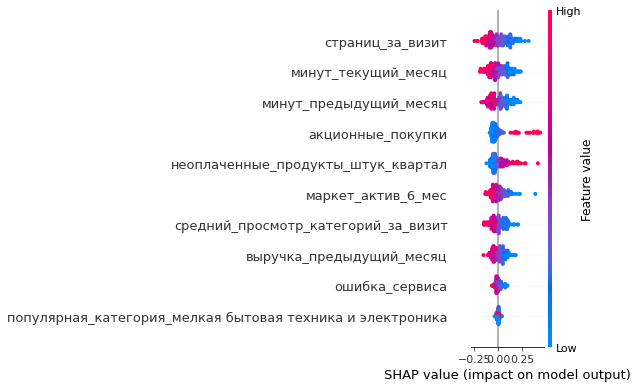

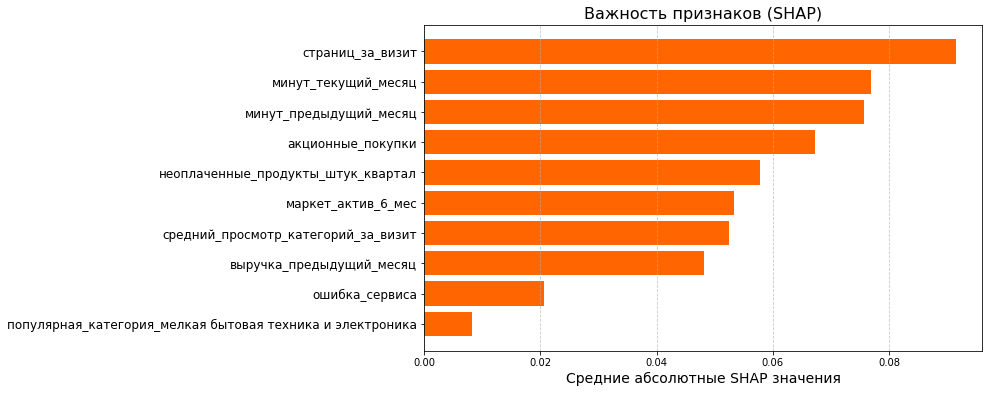

In [55]:
# Преобразование данных через ColumnTransformer
svc_best_model = search.best_estimator_
preprocessor = svc_best_model.named_steps['preprocessor']

# Применение трансформации
X_train_transformed = preprocessor.transform(X_train)

# Получаем имена новых признаков после трансформации
new_feature_names = []

# Для категориальных признаков
ohe = preprocessor.named_transformers_['cat_ohe'].named_steps['encoder']
cat_feature_names = ohe.get_feature_names_out(cat_features)
new_feature_names.extend(cat_feature_names)

# Для числовых признаков
new_feature_names.extend(num_features)

# Применяем маску к новым именам признаков
selected_features_mask = svc_best_model.named_steps['feature_selection'].get_support()
selected_features = [new_feature_names[i] for i in range(len(new_feature_names)) if selected_features_mask[i]]

# Подвыборка данных для ускорения SHAP
X_sample = X_train_transformed[:, selected_features_mask][:200]

# Создание объяснителя SHAP
explainer = shap.KernelExplainer(
    svc_best_model.named_steps['model'].predict_proba,
    shap.kmeans(X_sample, 50)
)

# Расчет SHAP значений
shap_values = explainer.shap_values(X_sample, nsamples=50)

if isinstance(shap_values, list):
    shap_values_class_1 = shap_values[1]
else:
    shap_values_class_1 = shap_values[:, :, 1]

# Построение SHAP Beeswarm Plot
shap.summary_plot(
    shap_values_class_1,
    X_sample,
    feature_names=selected_features
)

# Дополнительный график средней важности признаков
shap_values_mean = np.abs(shap_values_class_1).mean(axis=0)
indices = np.argsort(shap_values_mean)

plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_features)), shap_values_mean[indices], color='#FF6501')
plt.yticks(range(len(selected_features)), np.array(selected_features)[indices], fontsize=12)
plt.xlabel('Средние абсолютные SHAP значения', fontsize=14)
plt.title('Важность признаков (SHAP)', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Промежуточные выводы по анализу важности признаков:
- Для анализа важности был использован метод SHAP, применённый к модели SVC.
---
**Наиболее значимые признаки:**
- **'страниц_за_визит'**: наиболее значимый признак. Чем больше страниц посещает пользователь, тем ниже вероятность снижения покупательской активности.
- **'минут_предыдущий_месяц'** и **'минут_текущий_месяц'**: большое время, проведённое на сайте, снижает вероятность снижения покупательской активности.
- **'акционные_покупки'**: признак со смешанным эффектом. Большие значения могут увеличивать или уменьшать вероятность в зависимости от контекста.
- **'неоплаченные_продукты_штук_квартал'**: большое количество неоплаченных товаров повышает вероятность снижения активности.
- **'средний_просмотр_категорий_за_визит'**: умеренно значимый признак. Чем больше категорий изучает пользователь, тем выше вероятность снижения активности.
---
**Общие выводы:**
- **Наиболее важные признаки**:
   - Основное внимание стоит уделить пользовательской активности: количеству посещаемых страниц, времени на сайте и количеству просмотров категорий.
- **Рекомендации для бизнеса**:
   - Повышать вовлечённость пользователей через улучшение удобства навигации (увеличение просмотренных страниц).
   - Удерживать покупателей, которые проводят мало времени на сайте, через персонализированные предложения или уведомления.
   - Снижать количество неоплаченных товаров (например, через упрощение процесса оформления заказа).

## Сегментация клиентов

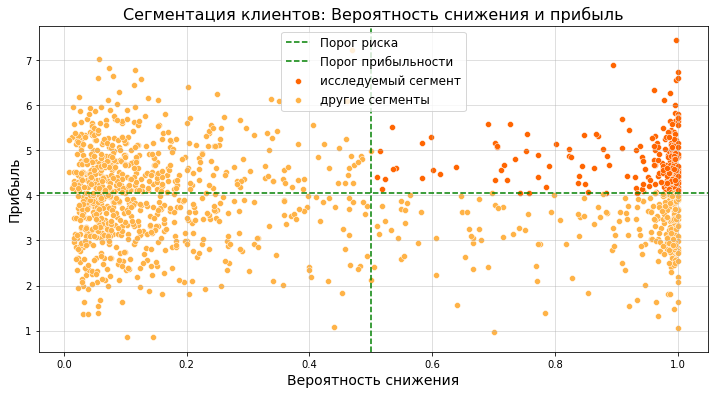

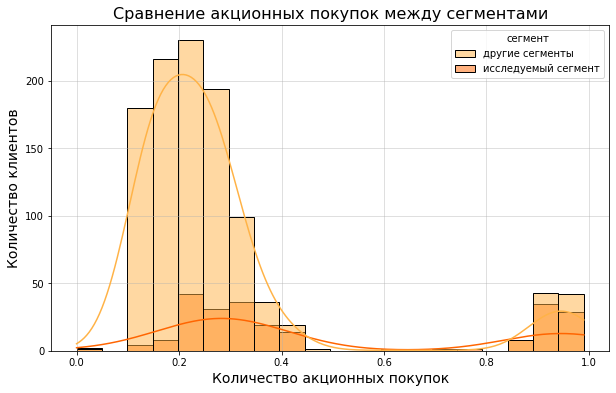

In [56]:
# Объединение merged_df с money_df
merged_df = merged_df.merge(money_df, on='id', how='left')

# Сегментация покупателей
# Добавляем вероятность снижения в DataFrame
merged_df['вероятность_снижения'] = search.predict_proba(merged_df.drop(['покупательская_активность', 'id'], axis=1))[:, 1]

# Определяем пороги для сегментации
threshold_risk = 0.5
threshold_profit = merged_df['прибыль'].median()

# Добавляем сегменты в DataFrame
merged_df['сегмент'] = 'другие сегменты'
merged_df.loc[
    (merged_df['вероятность_снижения'] > threshold_risk) & (merged_df['прибыль'] > threshold_profit),
    'сегмент'
] = 'исследуемый сегмент'

# График сегментации
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=merged_df[merged_df['сегмент'] == 'исследуемый сегмент'],
    x='вероятность_снижения', y='прибыль',
    label='исследуемый сегмент', color='#FF6501'
)
sns.scatterplot(
    data=merged_df[merged_df['сегмент'] == 'другие сегменты'],
    x='вероятность_снижения', y='прибыль',
    label='другие сегменты', color='#FFB347'
)

# Добавляем линии порогов
plt.axvline(x=threshold_risk, color='green', linestyle='--', label='Порог риска')
plt.axhline(y=threshold_profit, color='green', linestyle='--', label='Порог прибыльности')

# Настройки графика
plt.title('Сегментация клиентов: Вероятность снижения и прибыль', fontsize=16)
plt.xlabel('Вероятность снижения', fontsize=14)
plt.ylabel('Прибыль', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Анализ исследуемого сегмента
segment_analysis = merged_df[merged_df['сегмент'] == 'исследуемый сегмент']

# Сравнение акционных покупок между сегментами
plt.figure(figsize=(10, 6))
sns.histplot(
    data=merged_df, x='акционные_покупки', hue='сегмент', kde=True, bins=20,
    palette={'исследуемый сегмент': '#FF6501', 'другие сегменты': '#FFB347'}
)
plt.title('Сравнение акционных покупок между сегментами', fontsize=16)
plt.xlabel('Количество акционных покупок', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(alpha=0.5)
plt.show()

# Вывод ключевых статистик для факторов
factors_to_compare = ['страниц_за_визит', 'минут_предыдущий_месяц', 'неоплаченные_продукты_штук_квартал']
comparison_stats = segment_analysis[factors_to_compare].describe().T
comparison_stats['разница_с_другими'] = (
    segment_analysis[factors_to_compare].mean() - merged_df[merged_df['сегмент'] == 'другие сегменты'][factors_to_compare].mean()
)

### Промежуточные выводы по сегментации клиентов

**Критерии сегментации**:
  - Вероятность снижения активности больше 0.5;
  - Прибыль больше медианы по данным.
- Исследуемый сегмент содержит клиентов с высокой вероятностью снижения активности и значительной прибылью. Это ключевая группа, с которой имеет смысл работать для предотвращения потерь.
---
**Предложения для работы с сегментом:**
1. **Активизация акционных предложений**:
   - Разработка более привлекательных и персонализированных акций для увеличения лояльности.
   - Уведомления и напоминания о действующих скидках.
   
   
2. **Оптимизация процесса покупок**:
   - Устранение возможных технических барьеров на этапе завершения покупки (например, упрощение корзины или оплаты).
   - Анализ причин неоплаченных товаров для минимизации их количества.
   
   
3. **Увеличение вовлечённости**:
   - Персонализированная коммуникация с клиентами: рекомендации на основе их интересов (истории просмотров, предпочтений).
   - Уведомления о товарах, к которым они проявляли интерес, с дополнительными предложениями.
---
**Общие выводы:**
- **Сегмент для исследования**: Клиенты с высокой вероятностью снижения активности и высокой прибылью.
- **Основная цель**: Удержание этих клиентов и стимулирование их активности.
- **Почему важно**: Потеря клиентов из этого сегмента может существенно снизить общую прибыль компании.

### Анализ ключевого сегмента и рекомендации по увеличению активности

In [57]:
# Сегмент "Высокий риск + Высокая прибыль"
high_risk_high_profit = merged_df[merged_df['сегмент'] == 'исследуемый сегмент']

high_risk_high_profit_no_id = high_risk_high_profit.drop(columns=['id'], errors='ignore')

# Описание ключевых характеристик сегмента
print("Общие характеристики сегмента:")
display(high_risk_high_profit_no_id.describe().round(2))

Общие характеристики сегмента:


,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль,вероятность_снижения
count,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00,229.00
mean,3.62,4.05,602.66,0.49,2.45,3.84,3.91,4.66,4874.12,4577.03,5295.02,10.38,10.31,4.77,0.93
std,0.99,0.70,246.99,0.32,1.16,2.20,1.94,2.34,921.04,499.05,873.18,2.78,3.04,0.57,0.12
min,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,3078.30,5.00,4.00,4.05,0.51
25%,3.10,4.00,433.00,0.25,2.00,2.00,2.00,3.00,4396.00,4444.00,4606.20,8.00,8.00,4.32,0.94
50%,3.90,4.00,618.00,0.32,2.00,4.00,4.00,4.00,4995.00,4604.00,5299.60,10.00,10.00,4.65,0.98
75%,4.20,5.00,805.00,0.93,3.00,5.00,5.00,6.00,5553.50,4756.00,5976.20,12.00,12.00,5.06,1.00
max,5.60,5.00,1076.00,0.99,6.00,10.00,9.00,14.00,6399.50,5555.00,7467.90,19.00,22.00,7.43,1.00


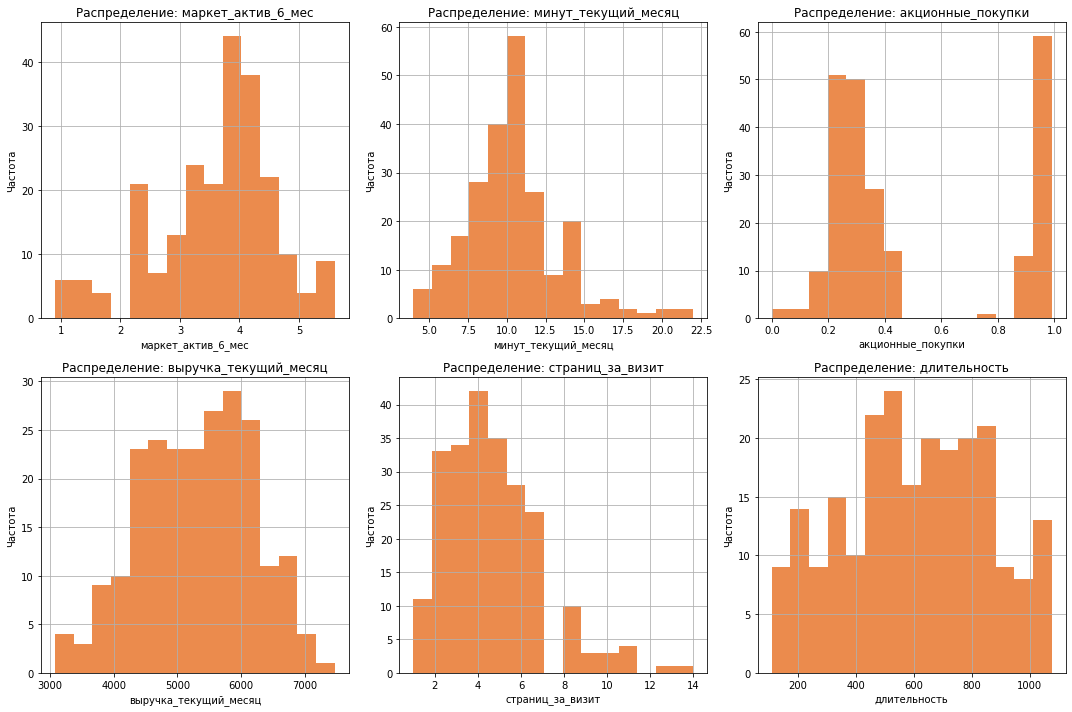

In [58]:
# Распределение ключевых признаков для сегмента
key_features = ['маркет_актив_6_мес', 'минут_текущий_месяц', 'акционные_покупки', 
                'выручка_текущий_месяц', 'страниц_за_визит', 'длительность']

# Построение гистограмм для анализа признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    high_risk_high_profit[feature].hist(bins=15, color='#E35A01', alpha=0.7)
    plt.title(f'Распределение: {feature}', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Частота', fontsize=10)
plt.tight_layout()
plt.show()

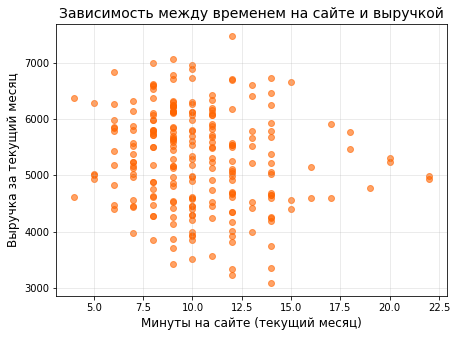

In [59]:
# Анализ распределения прибыли и времени на сайте
plt.figure(figsize=(7, 5))
plt.scatter(
    high_risk_high_profit['минут_текущий_месяц'],
    high_risk_high_profit['выручка_текущий_месяц'],
    alpha=0.6, color='#FF6501'
)
plt.title('Зависимость между временем на сайте и выручкой', fontsize=14)
plt.xlabel('Минуты на сайте (текущий месяц)', fontsize=12)
plt.ylabel('Выручка за текущий месяц', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

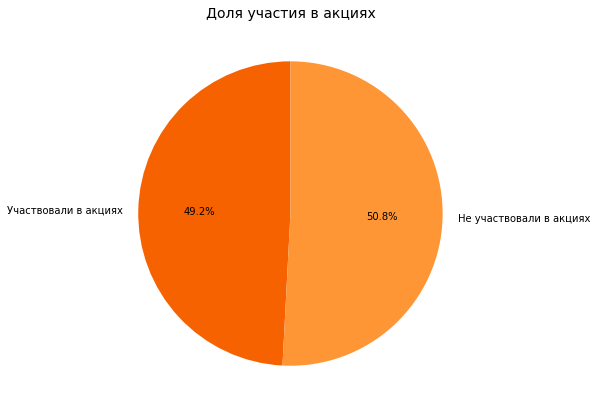

In [60]:
# Анализ активности по акциям
plt.figure(figsize=(7, 7))
plt.pie(
    [high_risk_high_profit['акционные_покупки'].mean(), 1 - high_risk_high_profit['акционные_покупки'].mean()],
    labels=['Участвовали в акциях', 'Не участвовали в акциях'],
    autopct='%1.1f%%',
    colors=['#F76201', '#FF9636'],
    startangle=90
)
plt.title('Доля участия в акциях', fontsize=14)
plt.show()

### Промежуточные выводы и предложения по увеличению покупательской активности

**Анализ сегмента "Высокий риск + Высокая прибыль"**
- **Характеристики сегмента**:
  - **Время на сайте**: Среднее время на сайте за текущий месяц составляет ~10 минут, с разбросом от 4 до 22 минут;
  - **Участие в акциях**: Почти половина клиентов (49.2%) участвовали в акционных предложениях, что подчеркивает их чувствительность к скидкам;
  - **Выручка**: Средняя выручка за текущий месяц составляет 5295 рублей, с разбросом от 3078 до 7467 рублей;
  - **Количество просмотренных страниц**: В среднем клиенты просматривают 4 страницы за визит;
  - **Длительность**: в среднем прошло 602 дня с момента регистрации покупателя на сайте.
---
**Основные наблюдения**
- Клиенты данного сегмента приносят высокую прибыль, но их активность в акциях остаётся неоптимальной, учитывая, что значительная доля не принимает участие в акциях.
- Взаимосвязь между временем на сайте и выручкой показывает, что более длительное взаимодействие на сайте может приводить к увеличению прибыли.
---
**Рекомендации по увеличению покупательской активности**
- **Оптимизация акций**:
   - Разработать персонализированные акционные предложения для клиентов этого сегмента;
   - Привязать акции к товарам, которые чаще всего посещают пользователи в этой группе.
- **Увеличение времени на сайте**:
   - Внедрить механизмы удержания клиентов на сайте, такие как рекомендательные системы или push-уведомления о скидках.
- **Стимулирование активности через геймификацию**:
   - Ввести накопительные баллы за просмотр страниц или участие в акциях с возможностью обмена на скидки.
- **Повышение удобства интерфейса**:
   - Упростить навигацию на сайте, чтобы клиенты проводили больше времени и с легкостью находили интересующие товары.

## Общий вывод

**Описание задачи**
- Цель проекта — разработать модель для прогнозирования вероятности снижения покупательской активности клиентов и предоставить рекомендации для увеличения активности на основе сегментации и анализа данных.
---
**Исходные данные и предобработка**
- Данные включали метрики покупательской активности, выручки, времени на сайте и другие характеристики клиентов.
- Предобработка данных включала:
  - Приведение текстовых значений к единому формату;
  - Обнаружение и исправление опечаток;
  - Выявление выбросов, которые оставлены для анализа;
  - Объединение таблиц в единый датафрейм для моделирования.
---
**Поиск лучшей модели**
- Для прогнозирования использовались несколько моделей (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC).
- Модели обучались с использованием настройки гиперпараметров через RandomizedSearchCV.
- Лучшая модель: **SVC с ядром rbf** (ROC-AUC на тестовых данных = **0.90**).
---
**Сегментация клиентов**
- На основе вероятности снижения активности и прибыльности клиентов выделены ключевые сегменты. Внимание сосредоточено на сегменте **"Высокий риск + Высокая прибыль"**:
- **Характеристики сегмента**:
  - Высокая прибыльность (средняя выручка 5295 рублей);
  - Среднее время на сайте — 10 минут, при этом почти половина клиентов не участвует в акциях.
- **Рекомендации**:
  - Персонализированные акционные предложения;
  - Внедрение рекомендаций и геймификации для увеличения вовлечённости;
  - Улучшение удобства навигации на сайте.
---
**Общие выводы**
- Построенная модель обеспечивает высокое качество прогнозирования, что позволяет эффективно выявлять клиентов с высоким риском снижения активности.
- Сегментация и анализ ключевых групп клиентов дают возможность направлять усилия на удержание наиболее прибыльных покупателей.
- Рекомендации, основанные на анализе данных, могут способствовать увеличению времени взаимодействия клиентов с сайтом и росту их покупательской активности.